In [1]:
# Google Drive mount for colab
#from google.colab import drive
#drive.mount('/content/drive')

# After mounting, /drive/MyDrive/ should appear on the left in Files tab
# Go to your own Google Drive, create a /cz4041/ folder, and upload the zip and csv files there
# It should appear in the files tab under /drive/MyDrive/cz4041/

# Data Pre Processing

In [2]:
# import packages
import os
import pprint
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ShuffleSplit, KFold,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
import pdb
from xgboost import XGBRegressor
from xgboost.sklearn import XGBClassifier
from tqdm.notebook import tqdm_notebook
from IPython.display import HTML, display



# pandas display options
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 300)
pd.set_option('float_format', '{:,.4f}'.format) # All float will be displayed in 4 d.p. with comma to separate thousands

In [3]:
# datasets paths
path = "../data"
#path = "/content/drive/MyDrive/cz4041/" # path to Google Drive, for colab
macro = os.path.join(path, "macro.csv")
train = os.path.join(path, "train.zip")
test = os.path.join(path,  "test.zip")

# place all datasets paths in a datasets dict
datasets = {}
datasets['macro'] = macro
datasets['train'] = train
datasets['test'] = test

# load dataframes into dfs dict
dfs = {}
for dataset_name, path in datasets.items():
    df = pd.read_csv(path)
    dfs[dataset_name] = df

# assign to own df variables when you want to use them individually
df_macro = dfs['macro']
df_train = dfs['train']
df_test = dfs['test']

## Overview of datasets

**Dataset size & Number of distinct datatypes**

In [4]:
for dataset_name, df in dfs.items():
    print("====== Dataset size - {}: {} ======".format(dataset_name , df.shape))
    print("Number of distinct datatypes: \n{}".format(df.dtypes.map(type).value_counts()))

====== Dataset size - macro: (2484, 100) ======
Number of distinct datatypes: 
<class 'numpy.dtype[float64]'>    94
<class 'numpy.dtype[object_]'>     4
<class 'numpy.dtype[int64]'>       2
dtype: int64
====== Dataset size - train: (30471, 292) ======
Number of distinct datatypes: 
<class 'numpy.dtype[int64]'>      157
<class 'numpy.dtype[float64]'>    119
<class 'numpy.dtype[object_]'>     16
dtype: int64
====== Dataset size - test: (7662, 291) ======
Number of distinct datatypes: 
<class 'numpy.dtype[int64]'>      159
<class 'numpy.dtype[float64]'>    116
<class 'numpy.dtype[object_]'>     16
dtype: int64


**Prepare dataset for datacleaning**

In [5]:
# Copy train price out to facilitate train & test split later
trainPrice = dfs["train"][["id", "price_doc"]].copy()

# Concat train dataset (minus price_doc) and test dataset for data cleaning
trainNoPrice = dfs["train"].drop("price_doc", axis = 1)

mergeData = pd.concat([trainNoPrice, dfs["test"]])
print(mergeData.shape)


(38133, 291)


## Cleaning of Data

**Since we are predicting price, we will want to drop columns that have low correlation value to 'price_doc'**

In [6]:
# get the correlation to 'price_doc' in train dataset
trainCorr = abs(dfs["train"].corr()["price_doc"])

# pick out features that have less than 5% correlation to be dropped
threshold = trainCorr <= 0.05
lowCorrFeats = trainCorr[threshold]
print(lowCorrFeats, ",", len(lowCorrFeats))

build_year                     0.0022
kitch_sq                       0.0287
school_quota                   0.0140
culture_objects_top_25_raion   0.0443
full_all                       0.0253
male_f                         0.0264
female_f                       0.0243
16_29_all                      0.0223
16_29_male                     0.0231
16_29_female                   0.0216
build_count_block              0.0315
build_count_wood               0.0425
build_count_frame              0.0303
build_count_panel              0.0201
build_count_foam               0.0107
build_count_slag               0.0240
build_count_mix                0.0330
build_count_1921-1945          0.0203
build_count_1971-1995          0.0097
build_count_after_1995         0.0259
cemetery_km                    0.0249
ID_railroad_station_walk       0.0218
water_km                       0.0266
mkad_km                        0.0206
big_market_km                  0.0483
prom_part_500                  0.0090
trc_sqm_500 

In [7]:
# drop
mergeData.drop(list(lowCorrFeats.index), axis = 1, inplace = True)
print(mergeData.shape)

(38133, 247)


In [8]:
# Drop columns with 'ID' in name as they do not provide much value

IDfeats = [feat for feat in mergeData.columns if "ID" in feat]
mergeData.drop(IDfeats, axis = 1, inplace = True)
print(mergeData.shape)

(38133, 241)


In [9]:
# Replace data in the following columns
mergeData.state.replace({33:3},inplace=True)
mergeData["material"].replace(to_replace = 3, value = 1, inplace = True)
mergeData["full_sq"].replace(to_replace = 0, value = np.nan, inplace = True)
mergeData["max_floor"].replace(to_replace = 0, value = np.nan, inplace = True)
mergeData["num_room"].replace(to_replace = 0, value = np.nan, inplace = True)

## Feature Engineering

In [10]:
# create 'year' and 'year_month' features from 'timestamp'
mergeData["year"] = mergeData["timestamp"].apply(lambda x: int(x[0:4]))
mergeData["year_month"] = mergeData["timestamp"].apply(lambda x: x[0:7])\

# create 'living_area_ratio', 'non_living_area' and 'non_living_area_ratio' from 'life_sq' and 'full_sq'
mergeData["living_area_ratio"] = mergeData["life_sq"] / mergeData["full_sq"]
mergeData["non_living_area"] = mergeData["full_sq"] - mergeData["life_sq"]
mergeData["non_living_area_ratio"] = mergeData["non_living_area"] / mergeData["full_sq"]

# create 'room_area_avg' from 'life_sq' and 'num_room'
mergeData["room_area_avg"] = mergeData["life_sq"] / mergeData["num_room"]

# create 'relative_floor' from 'floor' and 'max_floor'
mergeData["relative_floor"] = mergeData["floor"] / mergeData["max_floor"]

# create 'sub_area_building_height_avg' from 'sub_area' and 'max_floor'
sub_area_building_avg = mergeData.groupby('sub_area').agg({'max_floor':np.mean}).reset_index().rename(columns={'max_floor':'sub_area_building_height_avg'})
mergeData = pd.merge(mergeData, sub_area_building_avg, on = ['sub_area'], how = 'left')

# create 'sub_area_kremlin_dist_avg' from 'sub_area' and 'kremlin_km'
kremlin_dist = mergeData.groupby('sub_area').agg({'kremlin_km':np.nanmean}).reset_index().rename(columns={'kremlin_km':'sub_area_kremlin_dist_avg'})
mergeData = pd.merge(mergeData, kremlin_dist, on = ['sub_area'], how = 'left')

# create 'sales_year_month' from 'year_month'
sales_year_month = mergeData.groupby('year_month').size().reset_index().rename(columns={0:'sales_year_month'})
mergeData = pd.merge(mergeData, sales_year_month, on = ['year_month'], how = 'left')

print(mergeData.shape)

(38133, 251)


## Handling Missing Values

In [11]:
# find out columns that have missing values
missing_vals = ((mergeData.isna().sum()))
missing_vals.sort_values(ascending = False, inplace = True)
print(missing_vals[missing_vals > 0])
print("\r\nMissing Values Count: " + str(len(missing_vals[missing_vals > 0])))

hospital_beds_raion                      17859
room_area_avg                            14897
state                                    14253
max_floor                                10355
relative_floor                           10355
num_room                                  9586
material                                  9572
preschool_quota                           8284
cafe_sum_1000_max_price_avg               7746
cafe_sum_1000_min_price_avg               7746
cafe_avg_price_1000                       7746
living_area_ratio                         7562
non_living_area_ratio                     7562
non_living_area                           7562
life_sq                                   7559
build_count_brick                         6209
raion_build_count_with_builddate_info     6209
build_count_before_1920                   6209
build_count_monolith                      6209
build_count_1946-1970                     6209
raion_build_count_with_material_info      6209
cafe_sum_1500

In [12]:
# get the missing values in percentage
missing_vals_pct = ((mergeData.isna().sum()) / len(mergeData))
missing_vals_pct.sort_values(ascending = False, inplace = True)
print(missing_vals_pct[missing_vals_pct > 0])
print("\r\nMissing Values Count: " + str(len(missing_vals_pct[missing_vals_pct > 0])))

hospital_beds_raion                     0.4683
room_area_avg                           0.3907
state                                   0.3738
max_floor                               0.2715
relative_floor                          0.2715
num_room                                0.2514
material                                0.2510
preschool_quota                         0.2172
cafe_sum_1000_max_price_avg             0.2031
cafe_sum_1000_min_price_avg             0.2031
cafe_avg_price_1000                     0.2031
living_area_ratio                       0.1983
non_living_area_ratio                   0.1983
non_living_area                         0.1983
life_sq                                 0.1982
build_count_brick                       0.1628
raion_build_count_with_builddate_info   0.1628
build_count_before_1920                 0.1628
build_count_monolith                    0.1628
build_count_1946-1970                   0.1628
raion_build_count_with_material_info    0.1628
cafe_sum_1500

**Median Imputation for missing values lesser or equal to 30%**

In [13]:
print(missing_vals_pct[(missing_vals_pct > 0) & (missing_vals_pct <= 0.3000)].index)

for feat in missing_vals_pct[(missing_vals_pct > 0) & (missing_vals_pct <= 0.3000)].index:
    try:
        mergeData[feat].fillna(mergeData[feat].median(), inplace = True)
    except:
        mergeData[feat].fillna(mergeData[feat].mode()[0], inplace = True)

Index(['max_floor', 'relative_floor', 'num_room', 'material',
       'preschool_quota', 'cafe_sum_1000_max_price_avg',
       'cafe_sum_1000_min_price_avg', 'cafe_avg_price_1000',
       'living_area_ratio', 'non_living_area_ratio', 'non_living_area',
       'life_sq', 'build_count_brick', 'raion_build_count_with_builddate_info',
       'build_count_before_1920', 'build_count_monolith',
       'build_count_1946-1970', 'raion_build_count_with_material_info',
       'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
       'cafe_avg_price_1500', 'cafe_avg_price_2000',
       'cafe_sum_2000_max_price_avg', 'cafe_sum_2000_min_price_avg',
       'prom_part_5000', 'floor', 'metro_min_walk', 'metro_km_walk',
       'railroad_station_walk_min', 'railroad_station_walk_km', 'product_type',
       'green_part_2000', 'full_sq'],
      dtype='object')


In [14]:
# check remaining missing values in percentage
missing_vals_pct = ((mergeData.isna().sum()) / len(mergeData))
missing_vals_pct.sort_values(ascending = False, inplace = True)
print(missing_vals_pct[missing_vals_pct > 0])
print("\r\nMissing Values Count: " + str(len(missing_vals_pct[missing_vals_pct > 0])))

hospital_beds_raion   0.4683
room_area_avg         0.3907
state                 0.3738
dtype: float64

Missing Values Count: 3


**KNN Imputer for remaining missing values greater than 30%**

In [15]:
# sklearn KNNImputer
imputer = KNNImputer(n_neighbors=3)

missingCol = list(missing_vals_pct[missing_vals_pct > 0].index)

for i in tqdm_notebook(missingCol):
    mergeData[i] = imputer.fit_transform(mergeData[[i]])

  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
# check for any remaining missing values
missing_vals_pct = ((mergeData.isna().sum()) / len(mergeData))
missing_vals_pct.sort_values(ascending = False, inplace = True)
print(missing_vals_pct[missing_vals_pct > 0])
print("\r\nMissing Values Count: " + str(len(missing_vals_pct[missing_vals_pct > 0])))
print("\r\n" + str(mergeData.shape))

Series([], dtype: float64)

Missing Values Count: 0

(38133, 251)


## Prepare Train and Test datasets

In [17]:
# Using 'trainPrice' dataset from earlier to split 'mergeData' back into train and test datasets
xTrain = mergeData[mergeData["id"].isin(trainPrice["id"])]
xTrain = pd.merge(xTrain, trainPrice, on = ["id"], how = "inner")

xTest = mergeData[~mergeData["id"].isin(trainPrice["id"])]

yTrain = xTrain["price_doc"].apply(lambda j: np.log1p(j))
train_id = xTrain['id']
xTrain.drop(columns = ["id", "timestamp", "price_doc"], axis = 1, inplace = True)

In [18]:
# split into training and cross-validation
x_tr, x_cv, y_tr, y_cv = train_test_split(xTrain, yTrain, test_size=0.15,random_state=42)

In [19]:
# process categorical ('object') and numerical (non 'object') type data using label encoder

categoricals = xTrain.select_dtypes(include = ["object"]).copy()
numericals = xTrain.select_dtypes(exclude = ["object"])

# categoricals
for cat in categoricals:
  le = preprocessing.LabelEncoder()
  le.fit(x_tr[cat])

  x_cv[cat] = x_cv[cat].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  le.classes_ = np.append(le.classes_, '<unknown>')

  x_tr[cat] = le.transform(x_tr[cat])
  x_cv[cat] = le.transform(x_cv[cat])

# numericals
for num in numericals:
  min = x_tr[num].min()
  max = x_tr[num].max()
  x_tr[num] = (x_tr[num] - min)/(max-min)
  x_cv[num] = (x_cv[num] - min)/(max-min)

C:\Users\wehweh\AppData\Local\Temp/ipykernel_7216/3056538181.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cv[cat] = x_cv[cat].map(lambda s: '<unknown>' if s not in le.classes_ else s)
C:\Users\wehweh\AppData\Local\Temp/ipykernel_7216/3056538181.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr[cat] = le.transform(x_tr[cat])
C:\Users\wehweh\AppData\Local\Temp/ipykernel_7216/3056538181.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [20]:
# check any null values
print(x_tr.isnull().values.any())
print(x_cv.isnull().values.any())

False
False


# Testing the Models

In [21]:
# result array
resArr = []

## 1. Random Forest

In [22]:
# Select best features
sel = SelectFromModel(RandomForestRegressor(n_jobs = -1, max_depth = 10))
sel.fit(x_tr, y_tr)

trainFiltered = sel.transform(x_tr)
testFiltered = sel.transform(x_cv)

print("Train (after feature selection): " + str(trainFiltered.shape))
print("Test (after feature selection) : " + str(testFiltered.shape))

Train (after feature selection): (25900, 28)
Test (after feature selection) : (4571, 28)


In [23]:
# define parameter distributions to use for tuning
paramDist = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [10, 11, 12, 13, 14, 15]
}

# use RandomizedSearchCV to determine best values for parameters
randomSearchModel = RandomizedSearchCV(RandomForestRegressor(), param_distributions = paramDist, verbose = 10, n_jobs = -1, cv = 2, n_iter = 15)
randomSearchModel.fit(trainFiltered, y_tr)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 11, 12, 13, 14, 15],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   verbose=10)

In [24]:
print("Best Parameter values: ")
print(randomSearchModel.best_params_)
print("\r\nBest Score: ")
print(randomSearchModel.best_score_)

Best Parameter values: 
{'n_estimators': 300, 'max_depth': 15}

Best Score: 
0.39347805872935376


In [25]:
# Tune the Model with the best hyperparameters
rfrModel = RandomForestRegressor(
    n_estimators = randomSearchModel.best_params_['n_estimators'],
    max_depth = randomSearchModel.best_params_['max_depth'],
    random_state = 42,
    n_jobs = -1
)
rfrModel.fit(x_tr, y_tr)

RandomForestRegressor(max_depth=15, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [26]:
# predict on train data
yPred = rfrModel.predict(x_tr)
trainMse = mean_squared_error(y_tr, yPred)
print("Predict Train")
print("MSE : %.4f" % trainMse)
print("RMSE: %.4f" % sqrt(trainMse))

Predict Train
MSE : 0.0878
RMSE: 0.2962


In [27]:
# predict on test data
yPred = rfrModel.predict(x_cv)
testMse = mean_squared_error(y_cv, yPred)
print("Predict Test")
print("MSE : %.4f" % testMse)
print("RMSE: %.4f" % sqrt(testMse))

Predict Test
MSE : 0.2250
RMSE: 0.4743


In [28]:
# add to result array
resArr.append(["Random Forest", str("%.4f" % trainMse), str("%.4f" % testMse), str("%.4f" % sqrt(trainMse)), str("%.4f" % sqrt(testMse))])

###  Predict on test.csv test data

In [29]:
# do prep: process.. run pred
testRF = xTest.copy()
test_id = testRF['id']
testRF.drop(['id', 'timestamp'], axis = 1, inplace = True)

# process datatype
categoricals = xTrain.select_dtypes(include = ["object"]).copy()
numericals = xTrain.select_dtypes(exclude = ["object"])

for c in categoricals:
    le = preprocessing.LabelEncoder()
    le.fit(xTrain[c])

    testRF[c] = testRF[c].map(lambda s: "<unknown>" if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, "<unknown>")

    testRF[c] = le.transform(testRF[c])

for n in numericals:
    min = xTrain[n].min()
    max = xTrain[n].max()

    testRF[n] = (testRF[n] - min) / (max - min)

In [30]:
# predict using random forest model
test_pred = rfrModel.predict(testRF)

### Output File

In [31]:
# populate price_doc column with predicted prices
testRF['price_doc'] = np.expm1(test_pred)
testRF.head(10)

,full_sq,life_sq,floor,max_floor,material,num_room,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_brick,build_count_monolith,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1946-1970,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,...,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,year,year_month,living_area_ratio,non_living_area,non_living_area_ratio,room_area_avg,relative_floor,sub_area_building_height_avg,sub_area_kremlin_dist_avg,sales_year_month,price_doc
30471,0.0071,0.0028,0.0260,0.0690,0.0000,0.0000,0.6667,0,38,0.1180,0.7174,0.1598,0.0788,0.7300,1.0000,0.8462,0.7784,0.9286,0.5000,0.2462,0.1667,0.0000,0.4483,0.2500,0,0.1739,0.0284,0,0,0,0,0,0,0,0,0.7549,0.7727,0.7360,0.7500,0.7399,0.7597,0.4517,0.3794,0.4886,0.7300,0.7443,0.7145,0.7784,0.8013,0.7544,0.7581,0.7767,0.7383,0.7505,0.7700,0.7297,1.0000,0.3690,0.9134,1.0000,0.0916,0.5195,0.0205,0.0098,0.0124,0.0124,0.0027,0.0158,0.0432,0.0310,0.0858,0.0147,0.1774,0.1943,0.1943,...,0.1081,0.0000,0.2014,0.0210,0.0000,0.0000,0.0000,0.0000,0.0027,0.3750,0.3333,0.3493,0.0000,0.0000,0.0000,0.0115,0.0000,0.0000,0.0000,0.0143,0.0185,1.0000,0.0000,0.0926,0.0000,0.1951,0.0000,0.0000,0.0455,0.0275,0.0066,0.0084,0.0045,0.0045,0.0157,0.0000,0.0000,0.0000,0.0098,0.0183,0.5000,0.0000,0.0700,0.0000,0.2510,0.1580,0.0013,0.0030,0.0667,0.0652,0.0072,0.0115,0.0077,0.0062,0.0125,0.0000,0.0000,0.0000,0.0066,0.0400,0.5000,0.0000,0.0642,0.0476,1.0000,47,0.0056,0.5839,0.9944,0.0083,0.0060,0.5248,0.3324,0.2309,"5,143,394.3119"
30472,0.0147,0.0040,0.1039,0.1379,0.0000,0.1111,0.0000,1,103,0.1150,0.0059,0.5810,0.0136,0.0052,0.2416,0.0000,0.0051,0.0000,0.0000,0.2462,0.0000,0.0000,0.0000,0.0000,0,0.0435,0.0000,0,0,0,0,0,0,0,0,0.0052,0.0052,0.0051,0.0058,0.0063,0.0054,0.0055,0.0046,0.0060,0.0052,0.0053

In [32]:
# check output dir
if not os.path.exists("./output_models"):
    os.mkdir("./output_models")

# write id and predicted price_doc columns to csv
testRF['id'] = test_id
testRF[['id', 'price_doc']].to_csv('./output_models/output_random_forest.csv', index = False)

## 2. Decision Tree

In [33]:
dtModel = DecisionTreeRegressor()

# Define 'max_depth' params to use for tuning GridSearchCV
paramDepth ={'max_depth' : [5, 10, 11, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45, 50]}

gridSearchModel = GridSearchCV(dtModel, param_grid = paramDepth, verbose = 10, cv = 3, n_jobs = -1)
gridSearchModel.fit(x_tr, y_tr)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 11, 12, 13, 14, 15, 20, 25, 30,
                                       35, 40, 45, 50]},
             verbose=10)

In [34]:
print("Best Parameter values: ")
print(gridSearchModel.best_params_)
print("\r\nBest Score: ")
print(gridSearchModel.best_score_)

Best Parameter values: 
{'max_depth': 5}

Best Score: 
0.3323002293460929


In [35]:
# Tune the Model with the best hyperparameters
dtModel = DecisionTreeRegressor(
    max_depth = gridSearchModel.best_params_['max_depth'],
    random_state = 42
)
dtModel.fit(x_tr, y_tr)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [36]:
# predict on train data
yPred = dtModel.predict(x_tr)
trainMse = mean_squared_error(y_tr, yPred)
print("Predict Train")
print("MSE : %.4f" % trainMse)
print("RMSE: %.4f" % sqrt(trainMse))

Predict Train
MSE : 0.2341
RMSE: 0.4838


In [37]:
# predict on cross validation data
yPred = dtModel.predict(x_cv)
testMse = mean_squared_error(y_cv, yPred)
print("Predict Cross Validation")
print("MSE : %.4f" % testMse)
print("RMSE: %.4f" % sqrt(testMse))

Predict Cross Validation
MSE : 0.2449
RMSE: 0.4949


In [38]:
# add to result array
resArr.append(["Decision Tree", str("%.4f" % trainMse), str("%.4f" % testMse), str("%.4f" % sqrt(trainMse)), str("%.4f" % sqrt(testMse))])

### Predict on test.csv test data

In [39]:
# do the same prep: process.. run pred
testDT = xTest.copy()
testId = testDT["id"]
testDT.drop(["id", "timestamp"], axis = 1, inplace = True)

# process datatype
categoricals = xTrain.select_dtypes(include = ["object"]).copy()
numericals = xTrain.select_dtypes(exclude = ["object"])

for c in categoricals:
    le = preprocessing.LabelEncoder()
    le.fit(xTrain[c])

    testDT[c] = testDT[c].map(lambda s: "<unknown>" if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, "<unknown>")

    testDT[c] = le.transform(testDT[c])

for n in numericals:
    min = xTrain[n].min()
    max = xTrain[n].max()

    testDT[n] = (testDT[n] - min) / (max - min)

# predict using decision tree model
testPred = dtModel.predict(testDT)

**Output prediction to csv**

In [40]:
# populate price_doc column with predicted prices
testDT["price_doc"] = np.expm1(testPred)
testDT["id"] = testId

In [41]:
# check output dir
if not os.path.exists("./output_models"):
    os.mkdir("./output_models")

# write id and predicted price_doc columns to csv
testDT[["id", "price_doc"]].to_csv("./output_models/output_decisiontree.csv", index = False)

## 3. XGBoost (eXtreme Gradient Boost)

**Tune Hyperparameters**

In [42]:
xgbModel = XGBRegressor(nthread = -1)

# define parameter distributions to use for tuning
paramDist = {
    "colsample_bytree": [0.1, 0.25, 0.3, 0.5, 0.75, 0.8, 1],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1, 0.13, 0.15],
    "max_depth": [10, 11, 12, 13, 14, 15],
    "n_estimators": [50, 100, 150, 200],
    "subsample": [0.1, 0.3, 0.5, 0.7, 1]
}

# use RandomizedSearchCV to determine best values for hyperparameters
randomSearchModel = RandomizedSearchCV(xgbModel, param_distributions = paramDist, verbose = 10, n_jobs = -1, cv = 2, n_iter = 15)
randomSearchModel.fit(x_tr, y_tr)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                   

In [43]:
print("Best Hyperparamter values: ")
print(randomSearchModel.best_params_)
print("\r\nBest Score: ")
print(randomSearchModel.best_score_)

Best Hyperparamter values: 
{'subsample': 1, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.25}

Best Score: 
0.35942363662125304


**Use best Hyperparameters in model**

In [44]:
# tune Model
xgbModel = XGBRegressor(
    colsample_bytree = randomSearchModel.best_params_["colsample_bytree"],
    learning_rate = randomSearchModel.best_params_["learning_rate"],
    max_depth = randomSearchModel.best_params_["max_depth"],
    n_estimators = randomSearchModel.best_params_["n_estimators"],
    subsample = randomSearchModel.best_params_["subsample"]
)
# fit model
xgbModel.fit(x_tr, y_tr)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.25,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [45]:
# predict on train data
yPred = xgbModel.predict(x_tr)
trainMse = mean_squared_error(y_tr, yPred)
print("Predict Train")
print("MSE : %.4f" % trainMse)
print("RMSE: %.4f" % sqrt(trainMse))

Predict Train
MSE : 0.0063
RMSE: 0.0794


In [46]:
# predict on cross validation data
yPred = xgbModel.predict(x_cv)
testMse = mean_squared_error(y_cv, yPred)
print("Predict Cross Validation")
print("MSE : %.4f" % testMse)
print("RMSE: %.4f" % sqrt(testMse))

Predict Cross Validation
MSE : 0.2355
RMSE: 0.4853


In [47]:
# add to result array
resArr.append(["XGBoost", str("%.4f" % trainMse), str("%.4f" % testMse), str("%.4f" % sqrt(trainMse)), str("%.4f" % sqrt(testMse))])

### Predict on test.csv test data

In [48]:
# do the same prep: process.. run pred
testXGB = xTest.copy()
testId = testXGB["id"]
testXGB.drop(["id", "timestamp"], axis = 1, inplace = True)

# process datatype
categoricals = xTrain.select_dtypes(include = ["object"]).copy()
numericals = xTrain.select_dtypes(exclude = ["object"])

for c in categoricals:
    le = preprocessing.LabelEncoder()
    le.fit(xTrain[c])

    testXGB[c] = testXGB[c].map(lambda s: "<unknown>" if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, "<unknown>")

    testXGB[c] = le.transform(testXGB[c])

for n in numericals:
    min = xTrain[n].min()
    max = xTrain[n].max()

    testXGB[n] = (testXGB[n] - min) / (max - min)

# predict using xgb model
testPred = xgbModel.predict(testXGB)

**Output prediction to csv**

In [49]:
# populate price_doc column with predicted prices
testXGB["price_doc"] = np.expm1(testPred)
testXGB["id"] = testId

In [50]:
# check output dir
if not os.path.exists("./output_models"):
    os.mkdir("./output_models")

# write id and predicted price_doc columns to csv
testXGB[["id", "price_doc"]].to_csv("./output_models/output_xgboost.csv", index = False)

## 4. SGD (Stochastic Gradient Descent) Regressor

**Tune Hyperparameters**

In [51]:
sgdModel = SGDRegressor()

# define parameter distributions to use for tuning
paramDist = {
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    "learning_rate": ['optimal'],
    "loss": ["squared_loss"],
    "max_iter": [500, 1000, 1500, 2000],
    "penalty": ["l2"]
}

# use RandomizedSearchCV to determine best values for hyperparameters
randomSearchModel = RandomizedSearchCV(sgdModel, param_distributions = paramDist, verbose = 10, n_jobs = -1, cv=3, n_iter = 15)
randomSearchModel.fit(x_tr, y_tr)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3, estimator=SGDRegressor(), n_iter=15, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                                  10.0, 100.0, 1000.0,
                                                  10000.0],
                                        'learning_rate': ['optimal'],
                                        'loss': ['squared_loss'],
                                        'max_iter': [500, 1000, 1500, 2000],
                                        'penalty': ['l2']},
                   verbose=10)

In [52]:
print("Best Hyperparamter values: ")
print(randomSearchModel.best_params_)
print("\r\nBest Score: ")
print(randomSearchModel.best_score_)

Best Hyperparamter values: 
{'penalty': 'l2', 'max_iter': 1000, 'loss': 'squared_loss', 'learning_rate': 'optimal', 'alpha': 10000.0}

Best Score: 
-243.08490046294347


**Use best Hyperparameters in model**

In [53]:
# tune Model
sgdModel = SGDRegressor(
    alpha = randomSearchModel.best_params_["alpha"],
    learning_rate = "optimal",
    loss = "squared_loss",
    max_iter = randomSearchModel.best_params_["max_iter"],
    penalty = "l2",
)
# fit model
sgdModel.fit(x_tr, y_tr)


SGDRegressor(alpha=10000.0, learning_rate='optimal')

In [54]:
# predict on train data
yPred = sgdModel.predict(x_tr)
trainMse = mean_squared_error(y_tr, yPred)
print("Predict Train")
print("MSE : %.4f" % trainMse)
print("RMSE: %.4f" % sqrt(trainMse))

Predict Train
MSE : 91.1125
RMSE: 9.5453


In [55]:
# predict on cross validation data
yPred = sgdModel.predict(x_cv)
testMse = mean_squared_error(y_cv, yPred)
print("Predict Cross Validation")
print("MSE : %.4f" % testMse)
print("RMSE: %.4f" % sqrt(testMse))

Predict Cross Validation
MSE : 90.4085
RMSE: 9.5083


In [56]:
# add to result array
resArr.append(["SGD", str("%.4f" % trainMse), str("%.4f" % testMse), str("%.4f" % sqrt(trainMse)), str("%.4f" % sqrt(testMse))])

### Predict on test.csv test data

In [57]:
# do the same prep: process.. run pred
testSGD = xTest.copy()
testId = testSGD["id"]
testSGD.drop(["id", "timestamp"], axis = 1, inplace = True)

# process datatype
categoricals = xTrain.select_dtypes(include = ["object"]).copy()
numericals = xTrain.select_dtypes(exclude = ["object"])

for c in categoricals:
    le = preprocessing.LabelEncoder()
    le.fit(xTrain[c])

    testSGD[c] = testSGD[c].map(lambda s: "<unknown>" if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, "<unknown>")

    testSGD[c] = le.transform(testSGD[c])

for n in numericals:
    min = xTrain[n].min()
    max = xTrain[n].max()

    testSGD[n] = (testSGD[n] - min) / (max - min)

# predict using sgd model
testPred = sgdModel.predict(testSGD)

**Output prediction to csv**

In [58]:
# populate price_doc column with predicted prices
testSGD["price_doc"] = np.expm1(testPred)
testSGD["id"] = testId

In [59]:
# check output dir
if not os.path.exists("./output_models"):
    os.mkdir("./output_models")

# write id and predicted price_doc columns to csv
testSGD[["id", "price_doc"]].to_csv("./output_models/output_sgd.csv", index = False)

## 5. AdaBoost (Adaptive Boosting)

**Tune 'n_estimators' parameter**

In [60]:
adbModel = AdaBoostRegressor()

# define 'n_estimators' distributions to use for tuning
paramDist = { "n_estimators": [50, 100, 150, 200, 250, 300] }

# use RandomizedSearchCV to determine best value for 'n_estimators'
randomSearchModel = RandomizedSearchCV(adbModel, param_distributions = paramDist, verbose = 10, n_jobs = -1, cv = 3)
randomSearchModel.fit(x_tr, y_tr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits


RandomizedSearchCV(cv=3, estimator=AdaBoostRegressor(), n_jobs=-1,
                   param_distributions={'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   verbose=10)

In [61]:
print("Best 'n_estimators' value: ")
print(randomSearchModel.best_params_["n_estimators"])
print("\r\nBest Score: ")
print(randomSearchModel.best_score_)

Best 'n_estimators' value: 
50

Best Score: 
-0.4884744829271992


**Use best 'n_estimators' value in model**

In [62]:
# tune Model
adbModel = AdaBoostRegressor(n_estimators = randomSearchModel.best_params_["n_estimators"])
# fit model
adbModel.fit(x_tr, y_tr)

AdaBoostRegressor()

In [63]:
# predict on train data
yPred = adbModel.predict(x_tr)
trainMse = mean_squared_error(y_tr, yPred)
print("Predict Train")
print("MSE : %.4f" % trainMse)
print("RMSE: %.4f" % sqrt(trainMse))

Predict Train
MSE : 0.5598
RMSE: 0.7482


In [64]:
# predict on cross validation data
yPred = adbModel.predict(x_cv)
testMse = mean_squared_error(y_cv, yPred)
print("Predict Cross Validation")
print("MSE : %.4f" % testMse)
print("RMSE: %.4f" % sqrt(testMse))

Predict Cross Validation
MSE : 0.5538
RMSE: 0.7442


In [65]:
len(yPred)

4571

In [66]:
# add to result array
resArr.append(["AdaBoost", str("%.4f" % trainMse), str("%.4f" % testMse), str("%.4f" % sqrt(trainMse)), str("%.4f" % sqrt(testMse))])

### Predict on test.csv test data

In [67]:
# do the same prep: process.. run pred
testAdB = xTest.copy()
testId = testAdB["id"]
testAdB.drop(["id", "timestamp"], axis = 1, inplace = True)

# process datatype
categoricals = xTrain.select_dtypes(include = ["object"]).copy()
numericals = xTrain.select_dtypes(exclude = ["object"])

for c in categoricals:
    le = preprocessing.LabelEncoder()
    le.fit(xTrain[c])

    testAdB[c] = testAdB[c].map(lambda s: "<unknown>" if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, "<unknown>")

    testAdB[c] = le.transform(testAdB[c])

for n in numericals:
    min = xTrain[n].min()
    max = xTrain[n].max()

    testAdB[n] = (testAdB[n] - min) / (max - min)

# predict using adb model
testPred = adbModel.predict(testAdB)

**Output prediction to csv**

In [68]:
# populate price_doc column with predicted prices
testAdB["price_doc"] = np.expm1(testPred)
testAdB["id"] = testId

In [69]:
# check output dir
if not os.path.exists("./output_models"):
    os.mkdir("./output_models")

# write id and predicted price_doc columns to csv
testAdB[["id", "price_doc"]].to_csv("./output_models/output_adaboost.csv", index = False)

# 6. LightGBM

In [70]:
def lgbm_predict(train, test, y_train):
    RS=1
    np.random.seed(RS)
    ROUNDS = 1500 # 1300,1400 all works fine
    params = {
        'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'learning_rate': 0.01 , #small learn rate, large number of iterations
            'verbose': -1,
            'num_leaves': 2 ** 5,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'bagging_seed': RS,
            'feature_fraction': 0.7,
            'feature_fraction_seed': RS,
            'max_bin': 100,
            'max_depth': 7,
            'num_rounds': ROUNDS,
    }
    train_lgb=lgb.Dataset(train,y_train)
    model=lgb.train(params,train_lgb,num_boost_round=ROUNDS)
    predict=model.predict(test)
#     predict=np.exp(predict)
    return predict

In [71]:
# do prep: process.. run pred
testLgbm = xTest.copy()
test_id = testLgbm['id']
testLgbm.drop(['id', 'timestamp'], axis = 1, inplace = True)

# process datatype
categoricals = xTrain.select_dtypes(include = ["object"]).copy()
numericals = xTrain.select_dtypes(exclude = ["object"])

for c in categoricals:
    le = preprocessing.LabelEncoder()
    le.fit(xTrain[c])

    testLgbm[c] = testLgbm[c].map(lambda s: "<unknown>" if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, "<unknown>")

    testLgbm[c] = le.transform(testLgbm[c])

for n in numericals:
    min = xTrain[n].min()
    max = xTrain[n].max()

    testLgbm[n] = (testLgbm[n] - min) / (max - min)

In [72]:
# predict on train data
lgbm_pred = lgbm_predict(x_tr, x_tr, y_tr)
trainMse = mean_squared_error(y_tr, lgbm_pred)
print("Predict Train")
print("MSE : %.4f" % trainMse)
print("RMSE: %.4f" % sqrt(trainMse))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Predict Train
MSE : 0.1414
RMSE: 0.3760


In [73]:
# predict on cross validation data
lgbm_pred = lgbm_predict(x_tr, x_cv, y_tr)
testMse = mean_squared_error(y_cv, lgbm_pred)
print("Predict Cross Validation")
print("MSE : %.4f" % testMse)
print("RMSE: %.4f" % sqrt(testMse))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Predict Cross Validation
MSE : 0.2117
RMSE: 0.4601


In [74]:
lgbm_pred

array([16.37145868, 15.52221449, 15.21597236, ..., 15.19071261,
       15.74439144, 15.82490189])

In [75]:
# add to result array
resArr.append(["LightGBM", str("%.4f" % trainMse), str("%.4f" % testMse), str("%.4f" % sqrt(trainMse)), str("%.4f" % sqrt(testMse))])

### Predict on test.csv

In [76]:
lgbm_pred = lgbm_predict(x_tr, testLgbm, y_tr)
lgbm_output=pd.DataFrame({'id':test_id,'price_doc':np.expm1(lgbm_pred)})
lgbm_output.to_csv('./output_models/output_lgbm.csv',index=False)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


## Test raw data on naive xgb

In [77]:
xtrainnxgb = dfs["train"].drop(["id", "timestamp", "price_doc"], axis=1).select_dtypes(include=['number','bool','category'])
ytrainnxgb = dfs['train']['price_doc'].copy()
testnxgb = dfs['test'].drop(["id", "timestamp"], axis=1).select_dtypes(include=['number','bool','category'])

In [78]:
xgbModel = XGBRegressor(eta=0.05, nthread = -1, objective='reg:linear',
    eval_metric='rmse', gamma=0)

# define parameter distributions to use for tuning
paramDist = {
    "colsample_bytree": [0.55, 0.7, 0.8, 0.85, 0.9, 1, 1.4],
    "learning_rate": [0.07, 0.08, 0.1, 0.12, 0.15],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "n_estimators": [200, 220, 240, 300],
    "subsample": [0.7, 0.8, 0.9, 1],
    "min_child_weight": [3, 4, 5, 6]
}

# use RandomizedSearchCV to determine best values for hyperparameters
randomSearchModel = RandomizedSearchCV(xgbModel, param_distributions = paramDist, verbose = 10, n_jobs = -1, cv = 2, n_iter = 20)
randomSearchModel.fit(xtrainnxgb, ytrainnxgb)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.59771744        nan 0.58460408 0.60800526 0.58068904
 0.59524717 0.59075785 0.57494798 0.5968936  0.5755111  0.57702976
 0.57216222 0.56617424 0.58360857 0.57431374 0.56528977        nan
 0.58728883 0.59626088]
  warnings.warn(


[20:47:25] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, eta=0.05,
                                          eval_metric='rmse', gamma=0,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=...
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                  

In [79]:
import xgboost as xgb

xgb_params = {
    'eta': 0.05,
    'learning_rate': randomSearchModel.best_params_["learning_rate"],
    'max_depth': randomSearchModel.best_params_["max_depth"],
    'min_child_weight': randomSearchModel.best_params_["min_child_weight"],
    'subsample': randomSearchModel.best_params_["subsample"],
    'n_estimators': randomSearchModel.best_params_["n_estimators"],
    'colsample_bytree': randomSearchModel.best_params_["colsample_bytree"],
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'gamma': 0
}

xtrainnxgb = dfs["train"]
xtrainnxgb=xtrainnxgb[(xtrainnxgb.price_doc>1e6) & (xtrainnxgb.price_doc!=2e6) & (xtrainnxgb.price_doc!=3e6)]
xtrainnxgb.loc[(xtrainnxgb.product_type=='Investment') & (xtrainnxgb.build_year<2000),'price_doc']*=0.895 
xtrainnxgb.loc[xtrainnxgb.product_type!='Investment','price_doc']*=0.96 #Louis/Andy's magic number

ytrainnxgb = xtrainnxgb['price_doc'].copy()
xtrainnxgb = xtrainnxgb.drop(["id", "timestamp", "price_doc"], axis=1).select_dtypes(include=['number','bool','category'])
testnxgb = dfs['test'].drop(["id", "timestamp"], axis=1).select_dtypes(include=['number','bool','category'])

for c in xtrainnxgb.columns:
    if xtrainnxgb[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(xtrainnxgb[c].values)) 
        xtrainnxgb[c] = lbl.transform(list(xtrainnxgb[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in testnxgb.columns:
    if testnxgb[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(testnxgb[c].values)) 
        testnxgb[c] = lbl.transform(list(testnxgb[c].values))
        #x_test.drop(c,axis=1,inplace=True)        


dtrain = xgb.DMatrix(xtrainnxgb, ytrainnxgb)
dtest = xgb.DMatrix(testnxgb)



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


[20:47:39] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:39] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimators", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:47:39] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:39] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimators", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly h

<AxesSubplot:>

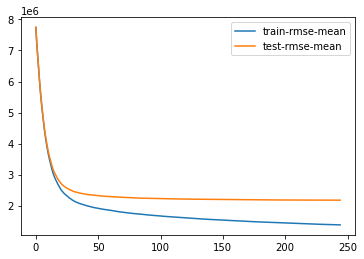

In [80]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [81]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

[20:48:10] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "n_estimators", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [82]:
testId = dfs['test']['id']
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': testId, 'price_doc': y_predict})
output.to_csv("./output_models/output_naivexgb.csv", index = False)

In [83]:
output.head()

,id,price_doc
0,30474,"5,251,370.0000"
1,30475,"7,929,659.5000"
2,30476,"5,347,367.5000"
3,30477,"5,808,495.0000"
4,30478,"4,969,001.5000"


## Process raw data for testing with LightGBM

In [84]:
def lgbm_process(train, test):
    #Remove the bad prices as suggested by Radar
    train=train[(train.price_doc>1e6) & (train.price_doc!=2e6) & (train.price_doc!=3e6)]
    train.loc[(train.product_type=='Investment') & (train.build_year<=2000),'price_doc']*=0.895 
    train.loc[train.product_type!='Investment','price_doc']*=0.96

  
    id_test = test.id
    times=pd.concat([train.timestamp,test.timestamp])
    num_train=train.shape[0]
    y_train = train["price_doc"]
    train.drop(['price_doc'],inplace=True,axis=1)
    da=pd.concat([train,test])
    da['na_count']=da.isnull().sum(axis=1)
    df_cat=None
    to_remove=[]
    for c in da.columns:
        if da[c].dtype=='object':
            oh=pd.get_dummies(da[c],prefix=c)
            if df_cat is None:
                df_cat=oh
            else:
                df_cat=pd.concat([df_cat,oh],axis=1)
            to_remove.append(c)
    da.drop(to_remove,inplace=True,axis=1)

    #Remove rare features,prevent overfitting
    to_remove=[]
    if df_cat is not None:
        sums=df_cat.sum(axis=0)
        to_remove=sums[sums<200].index.values
        df_cat=df_cat.loc[:,df_cat.columns.difference(to_remove)]
        da = pd.concat([da, df_cat], axis=1)
    x_train=da[:num_train].drop(['timestamp','id'],axis=1)
    x_test=da[num_train:].drop(['timestamp','id'],axis=1)
    #Log transformation, boxcox works better.
    y_train=np.log(y_train)
    
    return x_train, x_test, y_train

In [85]:
lgbm_train = pd.read_csv('../data/train.zip',parse_dates=['timestamp'])
lgbm_test = pd.read_csv('../data/test.zip',parse_dates=['timestamp'])
lgbmx_train, lgbmx_test, lgbmy_train = lgbm_process(lgbm_train, lgbm_test)
id_test =  lgbm_test.id
lgbm_pred = lgbm_predict(lgbmx_train, lgbmx_test, lgbmy_train)
lgbm_output = pd.DataFrame({'id':id_test,'price_doc':np.expm1(lgbm_pred)})
lgbm_output.to_csv('./output_models/lgbm_raw.csv',index=False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


**Display Result Table**

In [86]:
resdf = pd.DataFrame(resArr, columns = ["Model", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE"])
display(HTML(resdf.to_html(index=False)))

Model,Train MSE,Test MSE,Train RMSE,Test RMSE
Random Forest,0.0878,0.2250,0.2962,0.4743
Decision Tree,0.2341,0.2449,0.4838,0.4949
XGBoost,0.0063,0.2355,0.0794,0.4853
SGD,91.1125,90.4085,9.5453,9.5083
AdaBoost,0.5598,0.5538,0.7482,0.7442
LightGBM,0.1414,0.2117,0.3760,0.4601


**SGD Regressor has an appalling performance with extremely high MSE / RMSE scores**

## Trying a different approach:

## Step 1: Split train data into 80-20 split

In [87]:
# split into training and cross-validation
x_tr, x_cv, y_tr, y_cv = train_test_split(xTrain, yTrain, test_size=0.15,random_state=42)

In [88]:
# Effect code categorical variables:

num = xTrain.select_dtypes(exclude=['object'])
cat = xTrain.select_dtypes(include=['object']).copy()


for c in cat:
  labelEnc = preprocessing.LabelEncoder()
  labelEnc.fit(x_tr[c])

  x_cv[c] = x_cv[c].map(lambda s: '<unknown>' if s not in labelEnc.classes_ else s)
  labelEnc.classes_ = np.append(labelEnc.classes_, '<unknown>')

  x_tr[c] = labelEnc.transform(x_tr[c])
  x_cv[c] = labelEnc.transform(x_cv[c])

for c in num:
  min = x_tr[c].min()
  max = x_tr[c].max()

  x_tr[c] = (x_tr[c] - min)/(max-min)
  x_cv[c] = (x_cv[c] - min)/(max-min)

C:\Users\wehweh\AppData\Local\Temp/ipykernel_7216/707167389.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cv[c] = x_cv[c].map(lambda s: '<unknown>' if s not in labelEnc.classes_ else s)
C:\Users\wehweh\AppData\Local\Temp/ipykernel_7216/707167389.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr[c] = labelEnc.transform(x_tr[c])
C:\Users\wehweh\AppData\Local\Temp/ipykernel_7216/707167389.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

## Step 2: In train set, split the train set into A1 and A2 50-50 split
## Then we use A1 to do sampling with replacement to create a1,a2....ak(k samples).
## Now we create 'k' models, and train each of our models with these k samples.

In [89]:
A1, A2, y_a1, y_a2 = train_test_split(x_tr, y_tr, test_size=0.50)

In [90]:
A1 = A1.to_numpy()
A2 = A2.to_numpy()

y_a1 = y_a1.to_numpy()
y_a2 = y_a2.to_numpy()

print(A1.shape, A2.shape)

(12950, 249) (12950, 249)


### Generate random samples

In [91]:
import random

def generating_samples(input_, target_):
     
    s_rows = random.sample(range(len(input_)),int(len(input_)*0.60))  
    sample_data = list()
    target_data = list()
    
    for i in s_rows:
      sample_data.append(input_[i])
        
    target_data = target_[s_rows].tolist()
    
    
    
    return sample_data, target_data, s_rows

In [92]:
# Create 200 samples using generating_samples function
input_data =[]
output_data =[]
selected_rows = []

f = 200

for i in tqdm_notebook(range(f)):
    a,b,c = generating_samples(A1, y_a1)
    input_data.append(a)
    output_data.append(b)
    selected_rows.append(c)

  0%|          | 0/200 [00:00<?, ?it/s]

## Regression Decision Tree

In [93]:
list_all_models = list()

for i in tqdm_notebook(range(len(input_data))):
    
    k = np.array(input_data[i])
    j = np.array(output_data[i])
      
    model = DecisionTreeRegressor(max_depth = None)
    model.fit(k,j)
    
    list_all_models.append(model)



  0%|          | 0/200 [00:00<?, ?it/s]

## Step 3: We pass the A2 set to each k models, then we will get k predictions for A2 for each model.

In [94]:
k_predictions = list()

for i in list_all_models:
  k_predictions.append(i.predict(A2))

In [95]:
k_predictions = np.array(k_predictions)
k_predictions = k_predictions.T
k_predictions.shape

(12950, 200)

## Step 4: We then use the k predictions to create a new dataset, and for A2, since we know it's target values, we can use the k predictions to train a meta model.

In [96]:
# Using Linear Regression Model
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(k_predictions, y_a2)

print("MSE for train is: ", mean_squared_error(reg.predict(k_predictions), y_a2))

MSE for train is:  0.22060914184361416


## Step 5: For the model evaluation, we use the 20% data that we kept as the test set. 
## Pass that test set to each base model and we will get 'k' predictions. 
## We then create a new dataset using these k predictions and pass it to our meta model to get the final prediction. We can calculate the models performance score using this final prediction as well as the targets for the test set.

In [97]:
# Testing the Model
test_pred = list()

for model in list_all_models:
  test_pred.append(model.predict(x_cv))

test_pred = np.array(test_pred)
test_pred = test_pred.T

print("Model Performance score for test data is: ", reg.score(test_pred, y_cv))

Model Performance score for test data is:  0.35790452874302425


In [98]:
# Mean Sqaured Error for test data is:

mse = mean_squared_error(reg.predict(test_pred), y_cv)
print(mse)

0.23238404920546463


### Predicting the house prices for test.csv file data

In [99]:
x_test = xTest.copy()
test_id = x_test['id']
x_test.drop(['id','timestamp'],axis=1,inplace=True)
print(x_test.shape)

(7662, 249)


In [100]:
# Predict the House prices
# Preparing test data:

num = xTrain.select_dtypes(exclude=['object'])
cat = xTrain.select_dtypes(include=['object']).copy()


for c in cat:
  labelEnc = preprocessing.LabelEncoder()
  labelEnc.fit(xTrain[c])

  x_test[c] = x_test[c].map(lambda s: '<unknown>' if s not in labelEnc.classes_ else s)
  labelEnc.classes_ = np.append(labelEnc.classes_, '<unknown>')

  x_test[c] = labelEnc.transform(x_test[c])

for c in num:
  min = xTrain[c].min()
  max = xTrain[c].max()

  x_test[c] = (x_test[c] - min)/(max-min)



In [101]:
# Predict the House prices 
# Testing the Model
test_pred = list()

for model in list_all_models:
  test_pred.append(model.predict(x_test))

test_pred = np.array(test_pred)
test_pred = test_pred.T
pred = reg.predict(test_pred)



In [102]:
x_test['price_doc'] = np.expm1(pred)
x_test.head(10)

,full_sq,life_sq,floor,max_floor,material,num_room,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_brick,build_count_monolith,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1946-1970,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,...,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,year,year_month,living_area_ratio,non_living_area,non_living_area_ratio,room_area_avg,relative_floor,sub_area_building_height_avg,sub_area_kremlin_dist_avg,sales_year_month,price_doc
30471,0.0071,0.0028,0.0260,0.0690,0.0000,0.0000,0.6667,0,38,0.1180,0.7174,0.1598,0.0788,0.7300,1.0000,0.8462,0.7784,0.9286,0.5000,0.2462,0.1667,0.0000,0.4483,0.2500,0,0.1739,0.0284,0,0,0,0,0,0,0,0,0.7549,0.7727,0.7360,0.7500,0.7399,0.7597,0.4517,0.3794,0.4886,0.7300,0.7443,0.7145,0.7784,0.8013,0.7544,0.7581,0.7767,0.7383,0.7505,0.7700,0.7297,1.0000,0.3690,0.9134,1.0000,0.0916,0.5195,0.0205,0.0098,0.0124,0.0124,0.0027,0.0158,0.0432,0.0310,0.0858,0.0147,0.1774,0.1943,0.1943,...,0.1081,0.0000,0.2014,0.0210,0.0000,0.0000,0.0000,0.0000,0.0027,0.3750,0.3333,0.3493,0.0000,0.0000,0.0000,0.0115,0.0000,0.0000,0.0000,0.0143,0.0185,1.0000,0.0000,0.0926,0.0000,0.1951,0.0000,0.0000,0.0455,0.0275,0.0066,0.0084,0.0045,0.0045,0.0157,0.0000,0.0000,0.0000,0.0098,0.0183,0.5000,0.0000,0.0700,0.0000,0.2510,0.1580,0.0013,0.0030,0.0667,0.0652,0.0072,0.0115,0.0077,0.0062,0.0125,0.0000,0.0000,0.0000,0.0066,0.0400,0.5000,0.0000,0.0642,0.0476,1.0000,47,0.0056,0.5839,0.9944,0.0083,0.0060,0.5248,0.3324,0.2309,"5,247,336.8339"
30472,0.0147,0.0040,0.1039,0.1379,0.0000,0.1111,0.0000,1,103,0.1150,0.0059,0.5810,0.0136,0.0052,0.2416,0.0000,0.0051,0.0000,0.0000,0.2462,0.0000,0.0000,0.0000,0.0000,0,0.0435,0.0000,0,0,0,0,0,0,0,0,0.0052,0.0052,0.0051,0.0058,0.0063,0.0054,0.0055,0.0046,0.0060,0.0052,0.0053

In [103]:
# Dump the test data with predicted price into the csv file
x_test['id'] = test_id
x_test[['id','price_doc']].to_csv('./output_models/output_custom.csv',index=False)